In [1]:
import numpy as np # importing numpy for matrix operations 
from scipy import *
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display 
import itertools
from IPython.display import display
import random
import operator
from random import choices, randint, randrange, random, sample, seed, uniform, choice
from collections import namedtuple
from typing import List, Optional, Callable, Tuple
from functools import partial
sns.set()
import random
from itertools import product
import re
from collections import OrderedDict
from operator import getitem
from pprint import pprint
from numpy import asarray
import copy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import sys

In [2]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [3]:
class IterRegistry(type):
    def __iter__(cls):
        return iter(cls._registry)

In [4]:
class MarketConfig: 
    #class attributes
    t0 = 2018 #The starting year for evaluation of the pay-offs
    T = 25  # Planning Horizon t = 2016,...,2040 # 100 year scope 
    year = np.arange(2018, 2018 + T)
    distance = np.array([23000]) #nautical miles #Doudnikoff & Lacoste(2014). 
    port_time =  np.array([240]) #hours ==> 10 days in a year  #Doudnikoff & Lacoste(2014).
    demand_18_21 = np.array([7000000,7200000,7200000,7800000]) #2018-2021 TEU data for europe asia based on unctad 2020in TEU 
    annual_working_time = np.array([6480])  #hours per year, assumption   #hours per year, assumption 
    initial_freight_rate = np.array([822])  ## in US$/TEU 
    #SFOC_main = np.array([206])  #g/kWh, specific daily main engine fuel oil consumption rate
    #SFOC_aux = np.array([221]) # specific fuel oil consumption of the auxiliary engine [g/kW h], 
    eng_load_main = np.array([0.8]) # % 
    eng_load_aux = np.array([0.5])  # engine load of the auxiliary engine [\%]


    def __init__(self, number_of_firms, pollution_decay_parameter, pollution_damage_parameter,
                 demand_income_elasticity, demand_price_elasticity, 
                 freight_rate, fuel_data, discount_rate ):
        '''__init__ a method to describe the poperty that the shipping market and simulation game has'''
        self.number_of_firms = number_of_firms
        self.pollution_decay_parameter = pollution_decay_parameter
        self.pollution_damage_parameter = pollution_damage_parameter
        self.demand_income_elasticity = demand_income_elasticity #Constant income elasticity #IMF
        self.demand_price_elasticity =  demand_price_elasticity #Constant own price elasticity#IMF
        self.freight_rate = freight_rate ## in US$/TEU
        self.fuel_data = fuel_data 
        self.discount_rate = discount_rate 
        #self.bau_industry_emission =  bau_industry_emission 
        #self.bau_pollution_stock = bau_pollution_stock
        #self.market_capacity = 0 #don 't need anymore
         
    
    #Don t need anymore
    #def get_market_capacity (self, firm_instance):
        #self.market_capacity += np.multiply(firm_instance.max_number_of_vessel, firm_instance.capacity) 
        #return self.market_capacity 
    
    def get_freight_rate_ratio(self):
        self.beta = np.true_divide(self.freight_rate, MarketConfig.initial_freight_rate) 
        #should be equal to 1, since we re keeping freight rate cst 
        return self.beta
   
    def get_market_demand(self):
        '''compute market level demand'''
        #---------> 1.Import real GDP growth data & compute GDP ratio : Source IMF@2020 #
        G_df = pd.read_csv('real_growth_rate.csv') #import IMF data
        
        #-------> 2.Construct GDP projection path 2022-2043 based on projection growth data 
        gdp_growth= G_df.values[:,7:28] #Read gdp growth from 2022-2,043; file begins with 2016 growth rates
        g =1 +(gdp_growth/100)  
        #self.gdp = np.array([100.00 for j in range(MarketConfig.T)])
        #for foo in range (1,MarketConfig.T):
        #    self.gdp[foo] = g[:,foo]* self.gdp[foo-1]
            
        #print(self.gdp)
        #--------->  "compute GDP ratio based on IMF@2020"
        gdp_ratio = np.array([np.float64(g[:,0]) for j in range(np.size(g))])
        for moo in range (np.size(g)):
            sub_g = g[:,:moo+1]
            #print(sub_g)
            gdp_ratio[moo] = np.prod(sub_g)  
    
        
        #--------->  "compute freight rate ratio"
        self.freight_rate_ratio_multiplied = np.power(self.beta, self.demand_price_elasticity)
        #print(freight_rate_ratio_multiplied)
        
        #---------> "Project Transport Demand (industry demand)"
        loo =np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), self.freight_rate_ratio_multiplied ) #Will need to be updated in case fuel prices are varied over time  
        predict_demand= np.multiply(loo, MarketConfig.demand_18_21[3])
        self.planing_market_demand = np.concatenate((MarketConfig.demand_18_21, predict_demand), axis=None) #concatenate the predicted values with the Untac data        
        self.market_demand = self.planing_market_demand[:MarketConfig.T]
        #print(Y) # size = 1 dimesion array with size T=35 years
        #self.market_psy = np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), MarketConfig.demand_18_21[3] )
        return self.market_demand #, self.gdp #, self.market_psy

In [5]:
class Firm:
    #class attributes intialisation, to be updated with the addition of each instance
    _registry = []
    
    def __init__(self, index, capacity, design_speed, 
                 min_speed, max_speed, main_engine_power, aux_engine_power,
                 fix_cost, fuel_type, SFOC_M, SFOC_A, market_share):
        '''__init__ a method to describe the poperty that all shipping firm have'''
        self._registry.append(self)
        self.index = index
        self.capacity = capacity # Vessel capacity in TEU per firm, 
        #self.max_number_of_vessel = max_number_of_vessel # # of vessels per firms
        self.design_speed = design_speed  #design speed of the vessel in knots
        self.min_speed = min_speed #min vessel speed
        self.max_speed = max_speed #max vessel speed         
        self.main_engine_power =  main_engine_power  # PS_m : main engine power in kW
        self.aux_engine_power =  aux_engine_power  # auxiliary engine power [kW] 
        self.fix_cost = fix_cost #Daily cost of vessel (USD/Day) $25,000
        self.fuel_type = fuel_type
        self.SFOC_M = SFOC_M
        self.SFOC_A = SFOC_A
        self.market_share = market_share # the firm's market share 
        #self.bau_emission = bau_emission
         
   
    # Firm methods # Reupdate to make market share as in input
    #def get_market_share(self , market_instance):
        #'''return market share of the firm accoding to it s capacity'''
        #self.transport_capacity = np.multiply(self.max_number_of_vessel , self.capacity)
        #self.market_share= np.true_divide(self.transport_capacity, market_instance.market_capacity)
        #return self.market_share
        
    #def get_firm_param(self, market_instance):
        #self.psy = np.multiply (self.market_share , market_instance.market_psy)
        #return self.psy
    
    def get_firm_demand(self, market_instance):
        self.firm_demand = np.multiply (self.market_share , market_instance.market_demand)
        #print("firme demand", self.firm_demand)
        return self.firm_demand 
    
    def update_vessel_speed(self, operational_speed):
        self.operational_speed = operational_speed
        #print(self.operational_speed)
        return self.operational_speed 
    
    def get_min_number_of_vessel(self, market_instance):
        self.time_at_sea = np.true_divide(market_instance.distance,  self.operational_speed) #returns a vector 
        #print( " operational_speed", self.operational_speed)
        #print( " self.time_at_sea", self.time_at_sea)
        self.voyage_time = self.time_at_sea + market_instance.port_time #returns a vector 
        self.number_of_trips_to_meet_demand = np.ceil(np.true_divide(self.firm_demand, self.capacity)) #returns a vector
        self.max_trips_per_vessel = np.floor(np.true_divide(market_instance.annual_working_time, self.voyage_time)) #returns a vector
        self.min_number_of_vessel_to_meet_demand = np.true_divide(self.number_of_trips_to_meet_demand, self.max_trips_per_vessel) #returns a vector
        #print("max_trips_per_vessel", self.number_of_trips_to_meet_demand)
        #print("min_number_of_vessel_to_meet_demand", self.min_number_of_vessel_to_meet_demand)
        return self.min_number_of_vessel_to_meet_demand, self.number_of_trips_to_meet_demand, self.time_at_sea 
    
    def get_number_of_vessel(self):
        self.number_of_vessel = np.ceil(self.min_number_of_vessel_to_meet_demand) #returns a vector
        #print("self.number_of_vessel", self.number_of_vessel)
        return self.number_of_vessel
            
    def get_ship_energy_efficiency(self, market_instance):
        '''ship effici = SFPC * ENGINE POWER * ENGINE LOAD)* (Vds)^-3 '''
        self.main_fuel_parameter = self.SFOC_M * market_instance.eng_load_main * self.main_engine_power * 10**(-6)#self.main_fuel_parameter =np.multiply(np.multiply(np.multiply(self.SFOC_M, market_instance.eng_load_main),self.main_engine_power), 10**(-6))
        self.ship_energy = np.multiply(self.main_fuel_parameter, np.power(self.design_speed, -3) )  
        #print("self.ship_energy", self.ship_energy)
        return self.ship_energy
        
    def get_main_fuel_cons(self, market_instance):
        ''' fuel consu = ship eff * d * V^2 * # of trips to meet demand'''
        self.moo_1 = np.multiply(market_instance.distance, self.ship_energy)
        self.moo_2 = np.power(self.operational_speed, 2)
        self.moo_3 = np.multiply(self.moo_1, self.moo_2)
        self.main_fuel_cons = np.multiply(self.moo_3 , self.number_of_trips_to_meet_demand)
        #print("self.main_fuel_cons ", self.main_fuel_cons )
        return self.main_fuel_cons #returns a vector
        
    def get_aux_fuel_cons(self, market_instance): 
        self.aux_fuel_parameter = np.multiply(np.multiply(np.multiply( self.SFOC_A, market_instance.eng_load_aux), self.aux_engine_power),  10**(-6)) #self.aux_fuel_parameter = self.SFOC_A * market_instance.eng_load_aux * self.aux_engine_power * 10**(-6)
        self.aux_fuel_cons =  np.true_divide((self.aux_fuel_parameter * self.number_of_trips_to_meet_demand * market_instance.distance), self.operational_speed)        
        #print("self.aux_fuel_cons",self.aux_fuel_cons)
        return self.aux_fuel_cons #returns a vector   
    
        
    def get_fuel_cost(self, market_instance):
        self.aux_fuel_cost =np.multiply(self.aux_fuel_cons, market_instance.fuel_data['MGO']['price'])  
        self.main_fuel_cost = np.multiply(self.main_fuel_cons, market_instance.fuel_data[self.fuel_type]['price'])   
        self.fuel_cost = self.main_fuel_cost + self.aux_fuel_cost 
        #print("self.fuel_cost", self.fuel_cost)
        return self.fuel_cost #returns a vector
    
    
    def get_firm_carbon_emission(self, market_instance):
        self.carbon_aux_emision_factor = market_instance.fuel_data['MGO']['carbon_factor']
        self.carbon_aux_emissions = np.multiply(self.carbon_aux_emision_factor, self.aux_fuel_cons )  
        self.carbon_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['carbon_factor']
        self.carbon_main_emissions =np.multiply(self.carbon_main_emision_factor, self.main_fuel_cons)  
        self.carbon_emissions = self.carbon_main_emissions + self.carbon_aux_emissions 
        #print("self.carbon_emissions", self.carbon_emissions )
        return self.carbon_emissions
    
    def get_firm_sulfur_emission(self, market_instance):
        self.sulfur_aux_emision_factor = market_instance.fuel_data['MGO']['sulfur_factor']
        self.sulfur_aux_emissions = np.multiply(self.sulfur_aux_emision_factor, self.aux_fuel_cons)  
        self.sulfur_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['sulfur_factor']
        self.sulfur_main_emissions = np.multiply(self.sulfur_main_emision_factor, self.main_fuel_cons)  
        self.sulfur_emissions = self.sulfur_main_emissions + self.sulfur_aux_emissions 
        #print("self.sulfur_emissions", self.sulfur_emissions)
        return self.sulfur_emissions      
    
    
    def get_firm_operating_cost(self):
        self.operating_cost = np.multiply(self.fix_cost, self.number_of_vessel)  #Fixed Cost
        return self.operating_cost
        
            
    def get_total_cost(self):
        self.total_cost = self.operating_cost + self.fuel_cost
        #print("self.total_cost", self.total_cost)
        return self.total_cost #returns a vector    
     
                 
    def get_revenue(self,market_instance):
        self.revenue = np.multiply(self.firm_demand, market_instance.freight_rate)
        #print("self.revenue", self.revenue)
        return self.revenue #returns a vector
    
    def get_period_profits(self):
        self.period_profit = self.revenue - self.total_cost
        #print("self.period_profit", self.period_profit)
        return self.period_profit #returns a vector

# 1. Simulation Parameters:

In [6]:
####################################### 1. Firm & Market specific Parameters ###########################################
                    #===========================>  Firm 1 Attributes <==========================#
index_1 = 1
capacity_1 = np.array([14000]) 
#max_number_of_vessel_1= np.array([100]) 
design_speed_1 = np.array([25.0]) #design speed of the vessel isn knots
min_speed_1 = 12.0
max_speed_1 = 28.0
main_engine_power_1 =np.array([89700])  # main engine power in kW
aux_engine_power_1 =np.array([14000])  # auxiliary engine power [kW] 
fix_cost_1 = np.array([50000*365])   #Daily cost of vessel (USD/Day) $25,000
fuel_type_1 = "ULSFO"
SFOC_M_1 = 175
SFOC_A_1 = 32
market_share_1 = 0.33 #UPDATE Firm 1's market share 
                    #===========================>  Firm 2 Attributes <==========================#
index_2 = 2
capacity_2 = np.array([8000])
#max_number_of_vessel_2 = np.array([100])
design_speed_2 = np.array([25.0])  #design speed of the vessel in knots
min_speed_2 = 12.0
max_speed_2 = 28.0
main_engine_power_2 = np.array([68500]) # main engine power in kW
aux_engine_power_2 =np.array([12000])   # auxiliary engine power [kW] 
fix_cost_2 =np.array([37618*365]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_2 = "ULSFO"
SFOC_M_2 = 133
SFOC_A_2 = 24
market_share_2 = 0.3 #UPDATE Firm 2's market share 
                    #===========================>  Firm 3 Attributes <==========================#
index_3 = 3
capacity_3 = np.array([6000])
#max_number_of_vessel_3 = np.array([100])
design_speed_3 = np.array([25.0])  #design speed of the vessel in knots
min_speed_3 = 12.0
max_speed_3 = 28.0
main_engine_power_3 = np.array([57100]) # main engine power in kW
aux_engine_power_3 =np.array([12900])   # auxiliary engine power [kW] 
fix_cost_3 =np.array([33466*365]) #Daily cost of vessel (USD/Day) $25,000
fuel_type_3 = "ULSFO"
SFOC_M_3 = 114
SFOC_A_3 = 26
market_share_3 = 0.33 #UPDATE Firm 3's market share 
                    #===========================> Market Attributes <==========================#
number_of_firms = 3
pollution_decay_parameter =  np.array([1])
pollution_damage_parameter =  np.array([1.5])
year  = MarketConfig.year
income_elasticity = np.array([0.8]) #Constant income elasticity #IMF
price_elasticity = np.array([-0.7])   #Constant own price elasticity#IMF
freight_rate = np.array([822]) ## in US$/TEU
fuel_data = pd.DataFrame(np.array([[422.50, 525.50, 597.00], 
                                [3.114,3.206,3.206],
                                [0.07,0.01,0.002]]),
                         columns=['HFO', 'ULSFO', 'MGO'],
                         index = ['price', 'carbon_factor', 'sulfur_factor'])
discount = np.array([0.02])  ##3  to 5 % transport canada ,#to be updated using the Ramsey rule,#pure rate of time preference of 1.5% + growth rate of consumption g * rate of risk conversion , an elasticity value of 2

# 2. Set up firm and market objects 

In [7]:
""" This cell needs to run once throughout the kernel"""
####################################### 2.Simulation Game Initialisation ###########################################
firm_1 = Firm(index_1, capacity_1, design_speed_1, 
                 min_speed_1, max_speed_1, main_engine_power_1, aux_engine_power_1,
                 fix_cost_1, fuel_type_1, SFOC_M_1, SFOC_A_1, market_share_1) 

firm_2 = Firm(index_2, capacity_2, design_speed_2, 
                 min_speed_2, max_speed_2, main_engine_power_2, aux_engine_power_2,
                 fix_cost_2, fuel_type_2, SFOC_M_2, SFOC_A_2, market_share_2) 

firm_3 = Firm(index_3, capacity_3,  design_speed_3, 
                 min_speed_3, max_speed_3, main_engine_power_3, aux_engine_power_3,
                 fix_cost_3, fuel_type_3,SFOC_M_3, SFOC_A_3, market_share_3) 

game_config = MarketConfig(number_of_firms, pollution_decay_parameter, pollution_damage_parameter, 
                           income_elasticity, price_elasticity, freight_rate, 
                           fuel_data, discount)

####################################### 3.Get market capacity #################################
#for  firm_object in Firm._registry:
#    market_capacity_sim = game_config.get_market_capacity(firm_object)

# 3. Demand

In [8]:
## Get freight ratio for passethrough
beta_sim = game_config.get_freight_rate_ratio()

# Get market demand  
#market_demand_sim, gdp_sim, market_psy_sim = game_config.get_market_demand()
market_demand_sim = game_config.get_market_demand()

# 7.Get firm level demand  
firm_1_demand_sim = firm_1.get_firm_demand(game_config)
#print("firm 1 demand", firm_1_demand_sim)
    
# 9.Get ship energy efficiency  
firm_1_ship_energy_sim = firm_1.get_ship_energy_efficiency(game_config)

# 7.Get firm level demand  
firm_2_demand_sim = firm_2.get_firm_demand(game_config)
#print("firm 2 demand", firm_2_demand_sim)


# 9.Get ship energy efficiency  
firm_2_ship_energy_sim = firm_2.get_ship_energy_efficiency(game_config)
#print("firm 2 ship energy", firm_2_ship_energy_sim)

# 7.Get firm level demand  
firm_3_demand_sim = firm_3.get_firm_demand(game_config)
#print("firm 3 demand", firm_3_demand_sim)


# 9.Get ship energy efficiency  
firm_3_ship_energy_sim = firm_3.get_ship_energy_efficiency(game_config)


In [9]:
market_demand_sim

array([ 7000000.        ,  7200000.        ,  7200000.        ,
        7800000.        ,  8104290.37379516,  8336865.5491866 ,
        8562867.59239633,  8788190.97193528,  9019443.51303361,
        9256781.23570516,  9500364.26547593,  9750356.94141652,
       10006927.92701742, 10270250.32398178, 10540501.78901267,
       10817864.65367329, 11102526.04740139, 11394678.02376047,
       11694517.69001338, 12002247.34010533, 12318074.59114637,
       12642212.52348514, 12974879.82446861, 13316300.9359847 ,
       13666706.2058873 ])

# 4. GA set up 

In [10]:
#====> Iinitialisation of chromo and population objects 
Chromo =  float
Population = List[Chromo]
#====> Iinitialisation of function objects; Define the Objects; They allow you to pass in only what you need during the evol function 
PopulateFunc = Callable[[], Population]
VesselProc = Callable[[Chromo, Firm], Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray , np.ndarray ,np.ndarray, np.ndarray, np.ndarray]]
Integrated_Solution_Combo_Func = Callable[[dict, list , np.ndarray, np.ndarray,] , dict]

SelectionFunc = Callable[[np.ndarray, np.ndarray], Tuple[Chromo, Chromo]]  #takes a population and a fitness fn to select 2 solutions to be the parents of our next generaation solution
CrossoverFunc = Callable[[Chromo, Chromo], Tuple[Chromo, Chromo]] #takes 2 genomes and returns 2 new genomes 
MutationFunc = Callable[[Chromo], Chromo] #takes 1 genome and sometimes returns a modified one
FitnessFunc = Callable[[Chromo], list] #int to refelct max # of vessel


### 1) GA specific functions 

In [11]:
#======> Generate Chromo
def generate_chromo(firm: Firm) :
    '''generate the chromos, ie, each firm s vessel speed in the planing horizon based on speed constraint; [v1,..,vt]'''
    #while True:
    chromo = np.random.uniform(firm.min_speed, firm.max_speed)  
        #if (vessel_proc(chromo, firm)[0] != 0).all():
            #break
        #print("chromo", chromo)
    return chromo  

#======> Generate Population
def generate_population(firm:Firm, size: int ):
    '''generate the population of the firm s vessel speed based on our coev choice param population size'''
    return  np.array([generate_chromo(firm) for _ in range(size)])

#=====> Select Parent Chromo 
#def selection_pair (chromo, weights, size): 
#    '''randomly select 2 chromo from the population based on their weights, ie , solution fitness''' 
#    print(chromo)
#    print(weights)
#    weights = np.asarray(weights).astype('float64')
#    weights = weights / np.sum(weights)
#    selected_index = np.random.choice(np.arange(size),size = 2, replace=False,p= weights)
#    #print("chromo[selected_index[0]]", chromo[selected_index[0]])
#    #print("chromo[selected_index[1]", chromo[selected_index[1]])
#    return chromo[selected_index[0]],chromo[selected_index[1]]

def selection_pair (population: Population, fitness_func: FitnessFunc, weights: list):
    
    weights = np.asarray(weights).astype('float64')
    weights = weights / np.sum(weights)    
    return  np.random.choice(np.hstack( population),
                            size = 2, 
                            replace=False,
                            p= weights) 

#=======> Child Chromo based on parent chrossover
def BLX_alpha_crossover (a: Chromo, b: Chromo, firm, sim_game) :
    #child = np.zeros(sim_game.T)
    #lower = np.zeros(sim_game.T)
    #upper = np.zeros(sim_game.T)
    #for i in range(sim_game.T): 
    lower = (min(a,b)) - ( (0.5) * (max(a,b) - min (a,b)))
    #print("lower", lower)
    upper= (max(a,b)) + ( (0.5) * (max(a,b) - min (a,b)))
    #print("upper", upper)
    lower= firm.min_speed if (lower < firm.min_speed) else lower
    upper= firm.max_speed if (upper > firm.max_speed) else upper
    child = np.random.uniform (lower, upper, 2)
    #print("child", child)
    
    return child

#=====>#mutation prob = 0.5
def mutation(chromo: Chromo, firm: Firm, sim_game, variance: float, probability: float = 0.1 ) : 
    #mutated_chromo = np.zeros(sim_game.T)
    #print("chromo",chromo)
    #for i in range(sim_game.T): 
    mutated_chromo = np.random.normal(chromo, variance, 1) if random.random() > probability else chromo
    #print("mutated_chromo ",mutated_chromo[i])
    mutated_chromo = firm.min_speed  if mutated_chromo < firm.min_speed  else mutated_chromo
    mutated_chromo = firm.max_speed if mutated_chromo  > firm.max_speed else mutated_chromo
    #print("mutated_chromo", mutated_chromo)
    return mutated_chromo
#====> 
def fitness_similarity_chech(max_fitness, number_of_similarity):
    result = 0
    similarity = 0
    for n in range(len(max_fitness)-1):
        if np.round(max_fitness[n], 3 ) == np.round(max_fitness[n+1],3):
            similarity += 1
        else:
            similarity = 0
    if similarity == number_of_similarity-1:
        result = 1
    return result

### 2. Vessel Operations and Fitness Evaluation

In [12]:
def fitness (chromo: Chromo, firm: Firm, sim_game: MarketConfig): 
    
    operational_speed_ = np.repeat (firm.update_vessel_speed(chromo),sim_game.T) # firm.update_vessel_speed(chromo)
    #print("operational_speed", operational_speed_)
    min_number_vessels_sim , trips_to_meet_demand_sim, time_at_sea_sim  = firm.get_min_number_of_vessel(sim_game)
    #print(min_number_vessels_sim, trips_to_meet_demand_sim, time_at_sea_sim )
    number_vessels_sim  = firm.get_number_of_vessel()
    #print("number_vessels_sim", number_vessels_sim)
    
    #if (number_vessels_sim > firm.max_number_of_vessel).any():
        #true 
        #return np.zeros(9) #np.array([0,..,0])
    #else:
    main_fuel_con_sim = firm.get_main_fuel_cons(sim_game)
    #print("main_fuel_con_sim", main_fuel_con_sim)
    aux_fuel_con_sim = firm.get_aux_fuel_cons(sim_game)
    #print("aux_fuel_con_sim", aux_fuel_con_sim)
    fuel_cost_sim = firm.get_fuel_cost(sim_game) 
    #fixed cost
    fixed_cost_sim = firm.get_firm_operating_cost()
    
    #print("fuel_cost_sim", fuel_cost_sim)
    total_cost_sim = firm.get_total_cost()
    #print("total_cost_sim", total_cost_sim)
    revenue_sim = firm.get_revenue(sim_game)
    #print("revenue_sim", revenue_sim)
    profit_vector_sim = firm.get_period_profits()
    #print("profit_vector_sim", profit_vector_sim)
    
    # discount rate
    discount_multiplier = np.power( 1+ sim_game.discount_rate, - np.arange(1,MarketConfig.T + 1))
    
    # discounted_period_profit
    discounted_period_profit = np.multiply( discount_multiplier, profit_vector_sim) 
    #print("discounted_period_profit", discounted_period_profit)
    
    # NPV
    payoff= np.sum(discounted_period_profit[firm.index - 1]) 
    #print("payoff", payoff)   
    
    
    
    carbon_emissions_sim = firm.get_firm_carbon_emission(sim_game) 
    #print("carbon_emissions_sim", carbon_emissions_sim)
    sulfur_emissions_sim = firm.get_firm_sulfur_emission(sim_game)

    
    return payoff, number_vessels_sim, main_fuel_con_sim, aux_fuel_con_sim, fuel_cost_sim, fixed_cost_sim, total_cost_sim , revenue_sim ,profit_vector_sim, carbon_emissions_sim, sulfur_emissions_sim

In [13]:
def run_evolution(populate_func: PopulateFunc,
                  fitness_func : FitnessFunc, 
                  mutation_func: MutationFunc,
                  crossover_func: CrossoverFunc,
                  firm,
                  size,
                  sim_game,
                  generation_limit,
                  number_of_similarity,
                  selection_func: SelectionFunc = selection_pair
                 ):
    """The evolutionnary main loop""" 
    #1. Genrate the 1st generation: Initial generation/population
    population =  populate_func(firm) 
    #print(population)
    
    #2 Simulate until you reach generation limit,
    i = 0
    progress = pd.DataFrame(columns=['Generation', 'Vessel Speed', 'Firm Net present value', 
                                'Number of vessels', 'main_fuel_con_sim', 'aux_fuel_con_sim',  'fuel_cost_sim',"fixed_cost_sim",
                                    'total_cost_sim','revenue_sim','profit_vector_sim', "carbon_emissions_sim",
                                    "sulfur_emissions_sim"])
    
    population_ledger =  pd.DataFrame(columns=['Generation', 
                                               'Vessel Speed'])
    
    # Create the next generation 
    for i in range(generation_limit):
        #Step 1 : Sort solutions in the population of generation i based on fitness to select the best 2 solutions;
        ## THE first 2 observations
        population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True) 
        ##payoff, number_vessels_sim, main_fuel_con_sim, aux_fuel_con_sim, fuel_cost_sim, total_cost_sim , revenue_sim ,profit_vector_sim
        ## remove emissions from BAU 
        progress = progress.append({'Generation': i,
                          'Vessel Speed': population[0],
                          'Firm Net present value':fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'main_fuel_con_sim': fitness_func(population[0])[2],
                          'aux_fuel_con_sim': fitness_func(population[0])[3], 
                          'fuel_cost_sim': fitness_func(population[0])[4], 
                          "fixed_cost_sim" : fitness_func(population[0])[5], 
                          'total_cost_sim' : fitness_func(population[0])[6], 
                          'revenue_sim' : fitness_func(population[0])[7],
                          'profit_vector_sim': fitness_func(population[0])[8],
                                   "carbon_emissions_sim":fitness_func(population[0])[9] , 
                                    "sulfur_emissions_sim" : fitness_func(population[0])[10]}, ignore_index=True) 
        
        population_ledger = population_ledger.append({'Generation': i,
                                                  'Vessel Speed': population}, ignore_index=True) 
        
        #Similarity check
        if fitness_similarity_chech(progress['Firm Net present value'], number_of_similarity) == 1:
            break
#         print(progress)
#         print (i)
#         print("Best vessel speed in the", i, "th generation is" ,population[0] ) 
#         print("Best fitness in the", i, "th generation is", fitness_func(population[0]))
    
              
        #Step 2: Implement elitism and pick the top 2 chromo(speed) in the population based on fitness for the next gernation 
        next_generation = population[0:2] #pick the top 2      
        max = np.sum([fitness_func(chromo)[0] for chromo in population])
        weights= np.hstack([fitness_func(chromo)[0] / max for chromo in population])
        weights[weights<0] = 0 #in case the NPV <0

        
        #Step 3: j in range 24 
        for j in range(int(len(population) / 2) - 1):
            #Step 1: Selection
            #parents = selection_func(population, weights = weights)
            parents = selection_func(population, fitness_func, weights = weights)

            #print("parent are", parents) 
            
            #Step 2: Crossover
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])
            

            #Step 3: mutation 
            offspring_a = mutation_func(offspring_a)
            offspring_b = mutation_func(offspring_b)
            #print("offspring a ", offspring_a) 
            #print("offspring b", offspring_b) 
            
            #Step 4: Next generation 
            next_generation += [offspring_a, offspring_b]
            
        #print("next generation",i, "is", next_generation)       
        population = next_generation #update current population with our next generation and start into the next round of the algo by sorting the population and checking if we reached our fitness limit 
    
    #Sort the population one last time in case we run out of generation  
    population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True)
    progress = progress.append({'Generation': i,
                          'Vessel Speed': population[0],
                          'Firm Net present value':fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'main_fuel_con_sim': fitness_func(population[0])[2],
                          'aux_fuel_con_sim': fitness_func(population[0])[3], 
                          'fuel_cost_sim': fitness_func(population[0])[4], 
                         "fixed_cost_sim" : fitness_func(population[0])[5], 
                          'total_cost_sim' : fitness_func(population[0])[6], 
                          'revenue_sim' : fitness_func(population[0])[7],
                          'profit_vector_sim': fitness_func(population[0])[8],
                         "carbon_emissions_sim":fitness_func(population[0])[9] , 
                            "sulfur_emissions_sim" : fitness_func(population[0])[10]}, ignore_index=True) 
    population_ledger = population_ledger.append({'Generation': i,
                                                  'Vessel Speed': population}, ignore_index=True) 
    #print(progress)
    return progress, population_ledger


# Run Evolution 

In [14]:
## Update with the right firm before size 
results, my_population_ledger  = run_evolution(
    populate_func = partial(generate_population,
                            size=1000),
     fitness_func= partial(fitness,
                           firm = firm_2,
                           sim_game= game_config), 
    
    mutation_func = partial (mutation,
                             firm = firm_2,
                             sim_game= game_config,
                             variance = 4,
                             probability = 0.05),
    
    
    crossover_func = partial (BLX_alpha_crossover, 
                              firm = firm_2,
                              sim_game= game_config),
    
    firm = firm_2, 
    size=1000,
    sim_game = game_config,
    generation_limit = 500,
    number_of_similarity =50)


In [15]:
results#["profit_vector_sim"][159]
my_population_ledger

,Generation,Vessel Speed
0,0,"[16.679456281107733, 16.68373311073066, 16.719..."
1,1,"[16.679456281107733, 16.68373311073066, [16.68..."
2,2,"[16.672698941275225, [16.672943307769696], [16..."
3,3,"[16.672698941275225, [16.672943307769696], [16..."
4,4,"[16.672698941275225, [16.672943307769696], [16..."
5,5,"[16.672698941275225, [16.672943307769696], [16..."
6,6,"[[16.667283383489114], 16.672698941275225, [16..."
7,7,"[[16.667283383489114], [16.67105993311361], [1..."
8,8,"[[16.666685427698226], [16.667283383489114], [..."
9,9,"[[16.666685427698226], [16.667283383489114], [..."


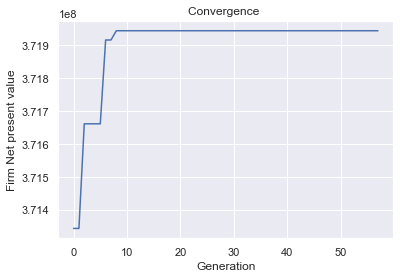

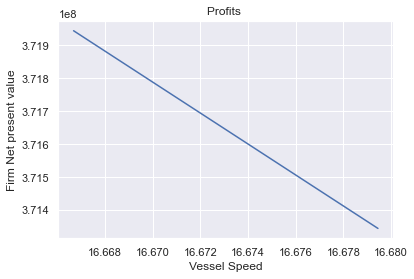

In [16]:
plt.plot(results['Generation'].values, results['Firm Net present value'].values)
plt.title("Convergence " )
plt.ylabel('Firm Net present value')
plt.xlabel('Generation')
plt.show()
#############
plt.plot(results['Vessel Speed'].values, results['Firm Net present value'].values)
plt.title("Profits " )
plt.ylabel('Firm Net present value')
plt.xlabel('Vessel Speed')
plt.show()

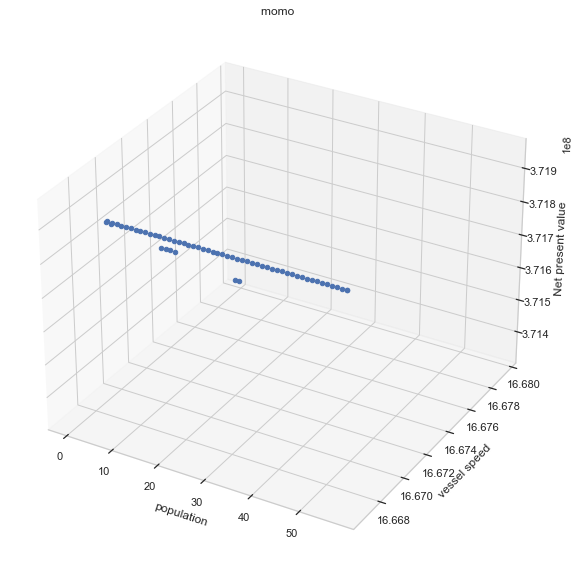

In [17]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = [results['Generation'].values]#[_][0] for _ in range(len(population_ledger_evolution['firm1']['generation0']))] #df['Happiness Score']
y = [results['Vessel Speed'].values]#[_][0] for _ in range(len(population_ledger_evolution['firm2']['generation0']))]
z = [results['Firm Net present value'].values] #[_][0] for _ in range(len(population_ledger_evolution['firm3']['generation0']))] #df['Health (Life Expectancy)']
g = ax.scatter(x, y, z, marker='o', depthshade=False)# cmap='Paired')
ax.set_xlabel("population")
ax.set_ylabel("vessel speed")
ax.set_zlabel("Net present value")
ax.set_title("momo ")
plt.show()

# Output Analysis 

In [18]:
optimum_solution_period = results.iloc[[-1]]
optimum_solution_period


,Generation,Vessel Speed,Firm Net present value,Number of vessels,main_fuel_con_sim,aux_fuel_con_sim,fuel_cost_sim,fixed_cost_sim,total_cost_sim,revenue_sim,profit_vector_sim,carbon_emissions_sim,sulfur_emissions_sim
58,57,[16.666685427698226],3.719441e+08,"[66.0, 68.0, 68.0, 74.0, 76.0, 79.0, 81.0, 83....","[783780.1040953683, 804641.1715047507, 804641....","[52263.301169193444, 53654.33960335448, 53654....","[443077635.5001245, 454870576.3689491, 4548705...","[906217620.0, 933678760.0, 933678760.0, 101606...","[1349295255.5001245, 1388549336.3689492, 13885...","[1726200000.0, 1775520000.0, 1775520000.0, 192...","[376904744.49987555, 386970663.6310508, 386970...","[2680355.157278185, 2751695.408612585, 2751695...","[7942.327643292069, 8153.720394254216, 8153.72..."


# Output Results 

In [19]:
periodes = range(MarketConfig.T) #optimum_solution.keys()
periodes
metrics = ["Vessel Speed", "Net present value", "Number of vessels","main_fuel_con_sim","aux_fuel_con_sim","fuel_cost_sim","fixed_cost_sim","total_cost_sim","revenue_sim","profit_vector_sim","carbon_emissions_sim","sulfur_emissions_sim"]
BAU_output = pd.DataFrame(columns = metrics, index = periodes ) # 
BAU_output

,Vessel Speed,Net present value,Number of vessels,main_fuel_con_sim,aux_fuel_con_sim,fuel_cost_sim,fixed_cost_sim,total_cost_sim,revenue_sim,profit_vector_sim,carbon_emissions_sim,sulfur_emissions_sim
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
for periode in periodes: 
        BAU_output["Vessel Speed"][periode] = optimum_solution_period["Vessel Speed"].values.astype(np.float64)[0]
        BAU_output["Net present value"][periode] = optimum_solution_period["Firm Net present value"].values.astype(np.float64)[0]
        BAU_output["Number of vessels"][periode] = optimum_solution_period["Number of vessels"].values[0][periode]
        BAU_output["main_fuel_con_sim"][periode] = optimum_solution_period["main_fuel_con_sim"].values[0][periode]
        BAU_output["aux_fuel_con_sim"][periode] = optimum_solution_period["aux_fuel_con_sim"].values[0][periode]
        BAU_output["fuel_cost_sim"][periode] = optimum_solution_period["fuel_cost_sim"].values[0][periode]
        BAU_output["fixed_cost_sim"][periode] = optimum_solution_period["fixed_cost_sim"].values[0][periode]# Add operating costs 
        BAU_output["total_cost_sim"][periode] = optimum_solution_period["total_cost_sim"].values[0][periode]
        BAU_output["revenue_sim"][periode] = optimum_solution_period["revenue_sim"].values[0][periode]
        BAU_output["profit_vector_sim"][periode] = optimum_solution_period["profit_vector_sim"].values[0][periode] #discounted ??
        BAU_output["carbon_emissions_sim"][periode] = optimum_solution_period["carbon_emissions_sim"].values[0][periode]
        BAU_output["sulfur_emissions_sim"][periode] = optimum_solution_period["sulfur_emissions_sim"].values[0][periode]

        
        
        

In [21]:
BAU_output

,Vessel Speed,Net present value,Number of vessels,main_fuel_con_sim,aux_fuel_con_sim,fuel_cost_sim,fixed_cost_sim,total_cost_sim,revenue_sim,profit_vector_sim,carbon_emissions_sim,sulfur_emissions_sim
0,16.666685,371944121.137111,66.0,783780.104095,52263.301169,443077635.500125,906217620.0,1349295255.500124,1726200000.0,376904744.499876,2680355.157278,7942.327643
1,16.666685,371944121.137111,68.0,804641.171505,53654.339603,454870576.368949,933678760.0,1388549336.368949,1775520000.0,386970663.631051,2751695.408613,8153.720394
2,16.666685,371944121.137111,68.0,804641.171505,53654.339603,454870576.368949,933678760.0,1388549336.368949,1775520000.0,386970663.631051,2751695.408613,8153.720394
3,16.666685,371944121.137111,74.0,873184.678707,58224.894458,493618810.65223,1016062180.0,1509680990.65223,1923480000.0,413799009.34777,2986099.091568,8848.296576
4,16.666685,371944121.137111,76.0,905966.356065,60410.811998,512150574.874669,1043523320.0,1555673894.874669,1998518006.177887,442844111.303218,3098205.200808,9180.485185
5,16.666685,371944121.137111,79.0,932787.728448,62199.289985,527312927.4203,1084715030.0,1612027957.4203,2055871044.429415,443843087.009115,3189928.381095,9452.275864
6,16.666685,371944121.137111,81.0,959609.100832,63987.767971,542475279.965932,1112176170.0,1654651449.965932,2111603148.284934,456951698.319002,3281651.561382,9724.066544
7,16.666685,371944121.137111,83.0,983450.320728,65577.526182,555952926.67316,1139637310.0,1695590236.67316,2167167893.67924,471577657.00608,3363183.277193,9965.65826
8,16.666685,371944121.137111,85.0,1010271.693112,67366.004169,571115279.218792,1167098450.0,1738213729.218792,2224194770.314087,485981041.095296,3454906.45748,10237.448939
9,16.666685,371944121.137111,87.0,1037093.065495,69154.482155,586277631.764423,1194559590.0,1780837221.764423,2282722252.724893,501885030.960469,3546629.637767,10509.239619


In [22]:
BAU_output.to_csv("30_2.csv", index=False)

In [23]:
my_population_ledger

,Generation,Vessel Speed
0,0,"[16.679456281107733, 16.68373311073066, 16.719..."
1,1,"[16.679456281107733, 16.68373311073066, [16.68..."
2,2,"[16.672698941275225, [16.672943307769696], [16..."
3,3,"[16.672698941275225, [16.672943307769696], [16..."
4,4,"[16.672698941275225, [16.672943307769696], [16..."
5,5,"[16.672698941275225, [16.672943307769696], [16..."
6,6,"[[16.667283383489114], 16.672698941275225, [16..."
7,7,"[[16.667283383489114], [16.67105993311361], [1..."
8,8,"[[16.666685427698226], [16.667283383489114], [..."
9,9,"[[16.666685427698226], [16.667283383489114], [..."


In [24]:
my_population_ledger['Vessel Speed'][0]

[16.679456281107733,
 16.68373311073066,
 16.719048708007293,
 16.719331863652165,
 16.743948250536477,
 16.76592171436552,
 16.770604811582054,
 16.79141263319474,
 16.81585771679283,
 16.856294564688024,
 16.861518142981115,
 16.870011667168136,
 16.872286594084425,
 16.894039740783242,
 16.900329629184228,
 16.92089288029635,
 16.928179474018307,
 16.928829311648425,
 16.92977156300531,
 16.930368096049172,
 16.934791412287364,
 16.95598265142759,
 16.96546085995585,
 16.96749315891291,
 16.977147871993175,
 16.9892815261638,
 17.000755182883765,
 17.02696200975921,
 17.06497344280305,
 17.080997804740143,
 17.089045769185702,
 17.11718816843362,
 17.145730978377166,
 17.145787186975827,
 17.15905033830049,
 17.162072240933963,
 17.1731150205258,
 17.19265042922614,
 17.193661939165818,
 17.200480957261014,
 17.215164148140047,
 17.218860507531723,
 17.240333798017126,
 17.25113244544096,
 17.25526588105618,
 17.272187798418038,
 17.282623504615977,
 17.29311051254794,
 17.297011073

ValueError: x and y must have same first dimension, but have shapes (59,) and (1000,)

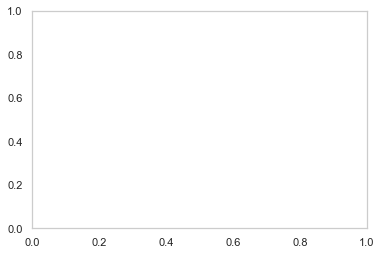

In [25]:


plt.plot(my_population_ledger['Generation'].values, my_population_ledger['Vessel Speed'][0])
plt.title("Convergence " )
plt.ylabel('Firm Net present value')
plt.xlabel('Generation')
plt.show()

### Evaluatin GA performance

### Profit,   Revenue, Cost CO2 Cost,  SOx Cos in 1 graph as a function of generation ??

### Firm 1, Period 1

## Export Results to spreadsheet

In [ ]:
writer = pd.ExcelWriter('results.xlsx', engine='xlsxwriter')   
for periode in results.keys():
    for firm in results[periode].keys():
        sheet_name = "period" + str(periode) + firm
        results[periode][firm].to_excel(writer, sheet_name = sheet_name, index =False)
writer.save()

In [ ]:
writer_1 = pd.ExcelWriter('optimum_solution.xlsx', engine='xlsxwriter')   
for periode in optimum_solution.keys():
    for firm in optimum_solution[periode].keys():
        sheet_name = "period" + str(periode) + firm
        optimum_solution[periode][firm].to_excel(writer_1, sheet_name = sheet_name, index =False)
writer_1.save()